# A notebook with all relevant code to run the evaluation


Imports

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import os
import pickle
%matplotlib inline
sns.set_style("whitegrid")
colors = ["#1f77b4", "#ff7f0e", "#e377c2", "#bcbd22", "#7f7f7f", "#d62728", "#98df8a"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

## Dataset generation

In [2]:
def markovTransition(p,n):
    if np.random.rand() < 0.95 or n==1:
        return p, False
    else:
        newState = np.random.randint(0, high=n)
        while newState == p:
            newState = np.random.randint(0, high=n)
        p = newState                
    return p, True

In [3]:
def GaussianTestData(mean=[-5,5], var=[1,1], l=500):
    if len(mean) != len(var):
        raise Exception("mean and var need to have the same amount of values")
    n = len(mean)
    currState = np.random.randint(n)
    states = []
    data = []
    trueCP = []
    for i in range(l):
        currState, cp = markovTransition(currState,n)
        states.append(currState)
        x = np.random.normal(loc=mean[currState] , scale=var[currState])
        data.append(x)
        if cp:
            trueCP.append(i+1)
    return data, trueCP

Maybe I want to create the datasets here?

## plotting functions

This function creates a subplot with the *data*, the *state probabilities*, the *estimated means* and the *predicted vs true change points*.

In [4]:

def plotMultiStateParticleSub(data, z, m, v, cp, trueCP):
        f, axarr = plt.subplots(4, sharex=True, figsize=(9, 6))
        axarr[0].set_xlim([-10,len(data)+10])
    ################ PREPARE DATA ################     
        states = len(z[0])
        zData = []
        meanData = []
        varData = []
        for i in range(states):
            zData.append(([],range(len(data))))
            meanData.append(([],range(len(data))))
            varData.append(([],range(len(data))))
        for t,z_t in enumerate(z):
            if len(z_t)>states:
                states += 1
                zData.append(([],range(t,len(data))))
                meanData.append(([],range(t,len(data))))
                varData.append(([],range(t,len(data))))
            for i,z_t_i in enumerate(z_t):
                zData[i][0].append(z_t_i)
                meanData[i][0].append(m[t][i])
                varData[i][0].append(v[t][i])
    ################ PLOT DATA ################ 
        axarr[0].plot(range(0,len(data)), data, 'r.')
        axarr[0].set_title("Data")
    ################ PLOT Z ################ 
        for z in zData:
            axarr[1].plot(z[1][:len(z[0])], z[0])
        axarr[1].set_ylim([-0.2,1.2])
        axarr[1].set_title("State Probability")
        axarr[1].set_yticks((0,0.5,1))
    ################ PLOT MEAN AND VAR################      
        for m, v in zip(meanData, varData):
            lowV = [mi-vi for (mi, vi) in zip(m[0],v[0])]
            highV = [mi+vi for (mi, vi) in zip(m[0],v[0])]
            axarr[2].plot(m[1][:len(m[0])], m[0])
            axarr[2].fill_between(m[1][:len(m[0])], lowV, highV, alpha=0.2)
        axarr[2].set_title("Estimated Means")
        axarr[2].set_ylim(min(data)-2, max(data)+2)
        axarr[2].scatter(range(0,len(data)), data, marker='x', color='red')
    ############### CHANGEPOINT ANALYSIS ##################
        for p in cp:
            axarr[3].axvline(x=p-1, ymin=0, ymax = 0.5, color='red', alpha=1.0)
        for p in trueCP:
            axarr[3].axvline(x=p-1, ymin=0.5, ymax = 1, color='green', alpha=1.0)
        axarr[3].axvline(x=cp[0]-1, ymin=0, ymax = 0.5, color='red', alpha=1.0, label='Prediction')
        axarr[3].axvline(x=trueCP[0]-1, ymin=0.5, ymax = 1, color='green', alpha=1.0, label='Truth')
        axarr[3].grid(axis='y')
        axarr[3].set_yticks(())
        axarr[3].set_title("Predicted Change Points")
        axarr[3].legend(frameon=True, framealpha=0.6)

        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Filter Algorithms

### MAP Bayesian Filter

In [5]:
class AndreasBayesFilterSOFT(object):   
    def __init__(self, n, M, means=[-1,1]):       
        self.M = M
        self.stateList = []
        self.prevZMax = -2
        for i in means:
            theta = [i,1]#TODO
            self.stateList.append(self.initState(1.0/n, theta))
        
    def initState(self, z, theta):
        return {'z':z, 'theta':theta, 'likelihood': [theta[0],1]}
        
    def computeTheta(self, _x, _theta, _z):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _z) * (_z*_x + theta[0]/theta[1])
        return theta
    
    def update(self, _x): 
        zSum = 0
        zMax = 0
        zMaxIndex = -1
        for i,s in enumerate(self.stateList):
            likelihood = scipy.stats.norm(s['likelihood'][0], s['likelihood'][1]).pdf(_x)
            transitionProb = 0
            for k,j in enumerate(self.M[:,i]):
                sTemp = self.stateList[k]
                transitionProb +=  sTemp['z'] * j.item(0) *\
                    scipy.stats.norm(sTemp['theta'][0], sTemp['theta'][1]).pdf(sTemp['likelihood'][0])
            unnormZ = likelihood * transitionProb
            s['unnormZ'] = unnormZ
            zSum += unnormZ 
            if unnormZ > zMax:
                zMax = unnormZ
                zMaxIndex = i 
        #normalising z
        for s in self.stateList:
            s['z'] = s['unnormZ']/zSum
            #update state of zMax
            s['theta'] = self.computeTheta(_x, s['theta'], s['z'])
            s['likelihood'][0] = s['theta'][0]   
            
        z = [x['z'] for x in self.stateList]
        mean = [x['likelihood'][0] for x in self.stateList]
        var = [x['likelihood'][1] for x in self.stateList]
        cpbool = zMaxIndex != self.prevZMax
        self.prevZMax = zMaxIndex        
        return z, mean, var, cpbool
    
    def run(self,data):
        z = []
        mean = []
        var = []
        cp = []
        for t,d in enumerate(data):
            zi, mi, vari, cpbool = self.update(d)
            z.append(list(zi))
            mean.append(list(mi))
            var.append(list(vari))
            if cpbool:
                cp.append(t+1)
        return z, mean, var, cp
    
    def getBCPinfo(self):        
        return self.stateList[self.prevZMax]['theta'][0] 

### Bayesian Filter
For now only two states

In [6]:
class BayesFilter(object):   
    def __init__(self, mean=[-1,1]):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [mean[0],1.1]
        self.theta1 = [mean[1],1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
        self.thetaProb = [0.5,0.5]
        
        self.prevZMax = -1
        
    def computeTheta(self, _x, _theta, _likelihood):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + _likelihood) * ((_likelihood*_x) + theta[0]/theta[1])
        return theta
    
    def computeIntegralSimple(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def computeIntegral(self, _x, _theta): 
        a = (_x**2 / (1 + (1 / _theta[1]))) + ((_theta[0]**2 / _theta[1]) / (1 + (1 / _theta[1])))
        b = (_x + (_theta[0]/_theta[1]))/(1 + (1 / _theta[1]))
        c = -1/(2 +( 1/(1 + (1 / _theta[1])))) * (a - b**2)
        ln = 0.5 * (np.log(1) - np.log(1 + 1/_theta[1]) - np.log(2* np.pi) - np.log(_theta[1]))
        return ln * c
    
    def update(self, _x):         
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)#0
        integral1 = self.computeIntegral(_x, self.theta1)#1
        
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        
        self.thetaProb = [1,1]
        
        thetaProb0 = (likelihood0 * self.thetaProb[0] * w0) + (self.thetaProb[0] * w1 * integral1)
        thetaProb1 = (likelihood1 * self.thetaProb[1] * w1) + (self.thetaProb[1] * w0 * integral0)

        self.thetaProb[0] = thetaProb0/(thetaProb0+thetaProb1)
        self.thetaProb[1] = thetaProb1/(thetaProb0+thetaProb1)
        
        self.theta0 = self.computeTheta(_x, self.theta0, self.thetaProb[0])
        self.theta1 = self.computeTheta(_x, self.theta1, self.thetaProb[1])
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]

        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        zMaxIndex = self.z.index(max(self.z))
        cpbool = zMaxIndex != self.prevZMax
        self.prevZMax = zMaxIndex 
        return [self.z[1], self.z[0]], [self.theta0[0], self.theta1[0]], [self.likelihoodParams0[1], self.likelihoodParams1[1]], cpbool 
    
    def run(self,data):
        z = []
        mean = []
        var = []
        cp = []
        for t,d in enumerate(data):
            zi, mi, vari, cpbool = self.update(d)
            z.append(list(zi))
            mean.append(list(mi))
            var.append(list(vari))
            if cpbool:
                cp.append(t+1)
        return z, mean, var, cp
    
    def getBCPinfo(self):
        mean = self.theta1[0]
        if max(self.z) is self.z[1]:
            mean = self.theta0[0]
        return mean

### Bootstrap Filter

In [7]:
class BootstrapFilterOpperMultiState(object):
    
    def __init__(self, d=1, likelihood=(0,1), prior=(1,-1), N=2000, \
                 noise = 0.1, particles=None,):
        
        self.noise = noise
        self.likelihood = likelihood
        self.numStates = len(prior)
        self.prior = prior
        
        self.cp = []
        self.prevMax = -1
        self.t=1
        
        if particles is not None:
            self.particles = particles
            self.weights = np.ones(len(self.particles))
        else:
            self.weights = np.ones(N)            
            state = np.random.randint(0, high=len(prior), size=N)
            p = [state]
            for a in prior:
                p.append(np.random.normal(loc=a, size=N))
            self.particles = np.stack(p, axis=-1)
                  
    def update(self, datum):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    1).pdf(p[p[0]+1])
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()          
        
        self.mean = []
        var = []
        z = np.zeros(len(self.prior))
        unique, counts = np.unique(self.particles[:,0], return_counts=True)
        d = dict(zip(unique, counts))
        for i in range(len(self.prior)):
            p = [x[1+i] for x in self.particles]
            self.mean.append(np.mean(p))
            var.append(np.var(p))
            if i in d:
                z[i] = d[i]
        z = z/z.sum()
        if not self.prevMax == z.argmax():
            self.cp.append(self.t)
        self.prevMax = z.argmax()
        self.t += 1
        return z, self.mean, var
        
    def markovTransition(self, p):
        if np.random.rand() < 0.9 or self.numStates == 1:
            return p
        else:
            newState = np.random.randint(0, high=self.numStates)
            while newState == p[0]:
                newState = np.random.randint(0, high=self.numStates)
            p[0] = newState 
        return p
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes        
        self.particles = self.particles[indexes]
        for i,t in enumerate(self.particles[0,1:]):
            self.particles[:,i+1] += np.random.normal(scale=1,size=N)
        self.weights.fill(1.0 / N)
    
    def run(self, data):
        particles = []
        z = []
        mean = []
        var = []
        for i, d in enumerate(data):
            z_t, m, v = self.update(d)        
            z.append(list(z_t))
            mean.append(list(m))
            var.append(list(v))
        return z, mean, var, self.cp
    
    def getBCPinfo(self):
        maxZ = self.prevMax
        return self.mean[maxZ]

### Bootstrap Filter with $\gamma$ and $\pi$ 

In [8]:
class BootstrapFilterOpperMultiStateGammaPi(object):
    # PATICLE: [state, gamma, pi 1, pi 2, pi 3, theta 1, theta 2, theta 3]
    def __init__(self, d=1, likelihood=(0,1), prior=(1,-1), N=2000, \
                 noise = 0.1, gamma=0.02, pi=(0.5,0.5)):
        
        self.noise = noise
        self.likelihood = likelihood
        self.numStates = len(prior)
        self.prior = prior
        
        self.cp = []
        self.prevMax = -1
        self.t=1
        
        self.gamma = gamma
        self.pi = pi

        self.weights = np.ones(N)            
        state = np.random.randint(0, high=len(prior), size=N)
        g = np.random.normal(scale=0.01, size=N) + gamma
        pt = [state,g]
        for a in pi:
            pi = np.abs((np.array(a)+np.random.normal(scale=0.01,size=N)))
            pi =pi/sum(pi)
            pt.append(pi)
        for a in prior:
            pt.append(np.random.normal(loc=a, size=N))
        self.particles = np.stack(pt, axis=-1)
                          
    def update(self, datum):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    1).pdf(p[p[0]+2+len(self.pi)])
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()                     
        self.mean = []
        var = []
        z = np.zeros(len(self.prior))
        unique, counts = np.unique(self.particles[:,0], return_counts=True)
        d = dict(zip(unique, counts))
        for i in range(len(self.prior)):
            p = [x[2+len(self.pi)+i] for x in self.particles] 
            self.mean.append(np.mean(p))
            var.append(np.var(p))
            if i in d:
                z[i] = d[i]
        z = z/z.max()
        if not self.prevMax == z.argmax():
            self.cp.append(self.t)
        self.prevMax = z.argmax()
        self.t += 1
        return z, self.mean, var
        
    def markovTransition(self, p):
        if np.random.rand() < self.gamma or self.numStates == 1:
            return p
        else:
            if p[2:2+len(self.pi)].sum != 1:
                p[2:2+len(self.pi)] = p[2:2+len(self.pi)]/p[2:2+len(self.pi)].sum() 
            cumsum = np.cumsum(p[2:2+len(self.pi)])
            cumsum[-1] = 1
            uniform = np.random.uniform()
            newState = np.searchsorted(cumsum, uniform)
            p[0] = newState
        return p
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes        
        self.particles = self.particles[indexes]
        for i,t in enumerate(self.particles[0,2+len(self.pi):]):
            self.particles[:,2+len(self.pi)+i] += np.random.normal(scale=1,size=N)
        self.weights.fill(1.0 / N)

    def run(self, data):
        particles = []
        z = []
        mean = []
        var = []
        for i, d in enumerate(data):
            l, m, v = self.update(d)        
            z.append(list(l))
            mean.append(list(m))
            var.append(list(v))
        return z, mean, var, self.cp
    
    def getBCPinfo(self):
        maxZ = self.prevMax
        return self.mean[maxZ]

## Evaluation

### Visual Evaluation

In [9]:
d, tcp = GaussianTestData(mean=[7,0], var=[1,1])


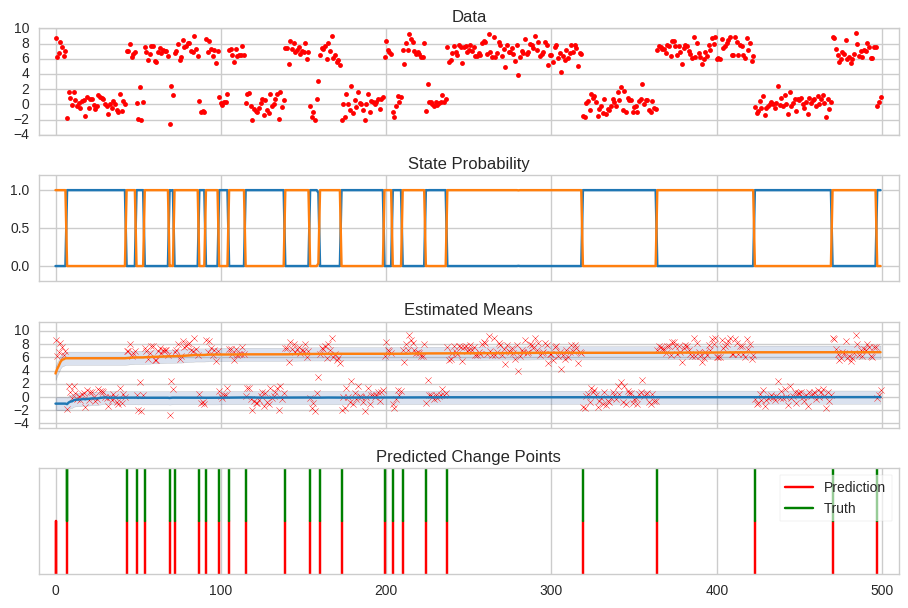

In [15]:
M = np.matrix([[0.9, 0.1],[0.1,0.9]])
cpd = AndreasBayesFilterSOFT(2,M)
z1,m1,v1, cp1 = cpd.run(d)
plotMultiStateParticleSub(d, z1, m1, v1, cp1, tcp)

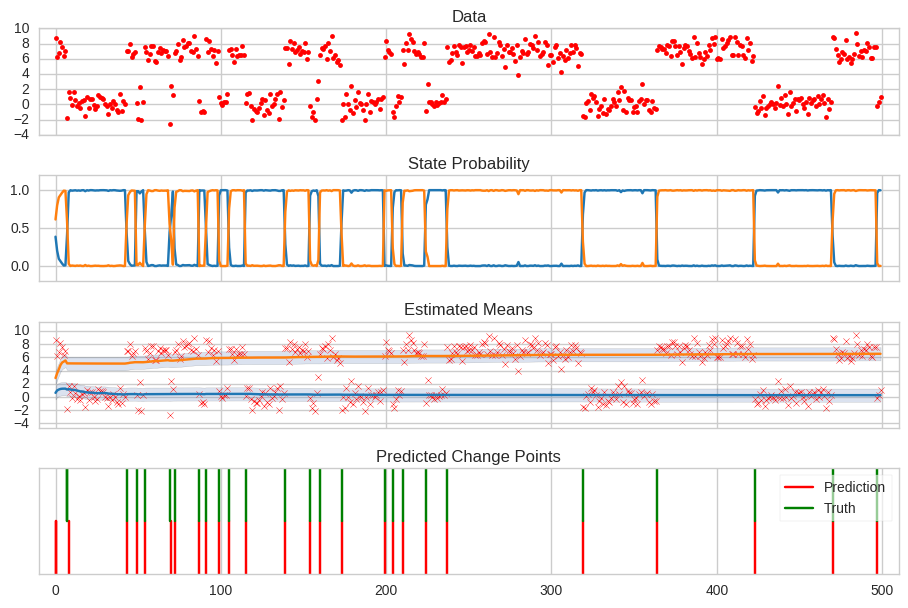

In [11]:
cpd = BayesFilter()
z2,m2,v2, cp2 = cpd.run(d)
plotMultiStateParticleSub(d, z2, m2, v2, cp2, tcp)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


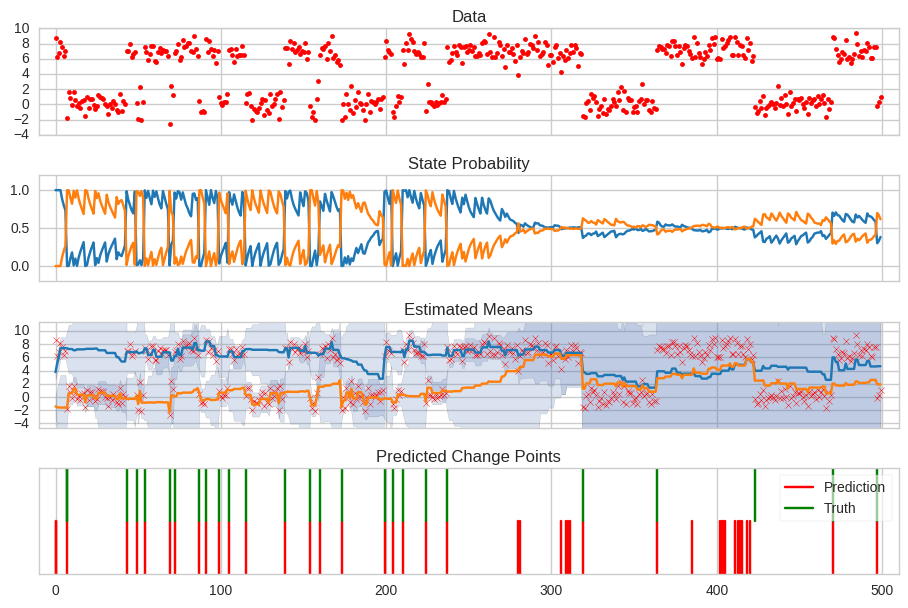

In [12]:
cpd = BootstrapFilterOpperMultiState()
z3,m3,v3, cp3 = cpd.run(d)
plotMultiStateParticleSub(d, z3, m3, v3, cp3, tcp)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


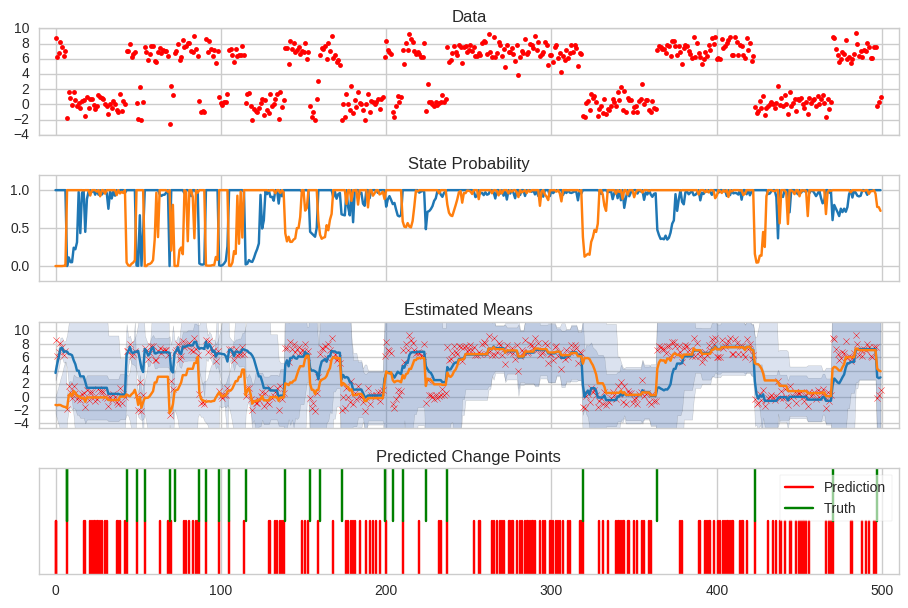

In [13]:
cpd = BootstrapFilterOpperMultiStateGammaPi()
z4,m4,v4, cp4 = cpd.run(d)
plotMultiStateParticleSub(d, z4, m4, v4, cp4, tcp)

### Experiment 1. Known Model
using data generated by a model with known variance
* mean convergance
* State prediction -- this seems to be very tricky
* posterior

In [2]:
import pickle

In [801]:
def createData():
    for d in range(100):
        m0 = 5# np.random.randint(5)
        m1 = -5#np.random.randint(5) * -1
        data = GaussianTestData(l=100)
        with open('dataset/datamodel-data/mean{0}-{1}_{2}.txt'.format(m0,m1*-1,d), 'a') as f:
            pickle.dump(data, f)

In [802]:
#createData()

In [812]:
def testAndreas():
    zl = []
    ml = []
    vl = []
    cpl = []
    for filename in os.listdir(os.getcwd()+'/dataset/datamodel-data/')[:10]:
        if filename[-1] == 't':
            m0 = int(filename[4])
            m1 = -1 * int(filename[6])
            with open('dataset/datamodel-data/{0}'.format(filename), 'rb') as f:
                d = pickle.load(f)
            cpd = AndreasBayesFilterSOFT(2,M)
            z,m,v,cp = cpd.run(d[0])
            zl.append(z)
            ml.append(m)
            vl.append(v)
            cpl.append(cp)
    with open('resultsAndreas.pickle', 'a') as f:
                pickle.dump((zl,ml,vl,cpl), f)
            
def testOpper():
    zl = []
    ml = []
    vl = []
    cpl = []
    for filename in os.listdir(os.getcwd()+'/dataset/datamodel-data/')[:10]:
        if filename[-1] == 't':
            m0 = int(filename[4])
            m1 = -1 * int(filename[6])
            with open('dataset/datamodel-data/{0}'.format(filename), 'rb') as f:
                d = pickle.load(f)
            cpd = BayesFilter()
            z,m,v,cp = cpd.run(d[0])
            zl.append(z)
            ml.append(m)
            vl.append(v)
            cpl.append(cp)
    with open('resultsOpper.pickle', 'a') as f:
                pickle.dump((zl,ml,vl,cpl), f)
            
def testPF():
    zl = []
    ml = []
    vl = []
    cpl = []
    for filename in os.listdir(os.getcwd()+'/dataset/datamodel-data/')[:10]:
        if filename[-1] == 't':
            m0 = int(filename[4])
            m1 = -1 * int(filename[6])
            with open('dataset/datamodel-data/{0}'.format(filename), 'rb') as f:
                d = pickle.load(f)
            cpd = BootstrapFilterOpperMultiState()
            z,m,v,cp = cpd.run(d[0][:])
            
            zl.append(z)
            ml.append(m)
            vl.append(v)
            cpl.append(cp)
            with open('resultsPF-{0}.pickle'.format(filename), 'a') as f:
                        pickle.dump((z,m,v,cp), f)
            print 'finished with file', filename
            
def testPFGammaPi():
    zl = []
    ml = []
    vl = []
    cpl = []
    for filename in os.listdir(os.getcwd()+'/dataset/datamodel-data/')[:10]:
        if filename[-1] == 't':
            m0 = int(filename[4])
            m1 = -1 * int(filename[6])
            with open('dataset/datamodel-data/{0}'.format(filename), 'rb') as f:
                d = pickle.load(f)
            cpd = BootstrapFilterOpperMultiStateGammaPi()
            z,m,v,cp = cpd.run(d[0])
            zl.append(z)
            ml.append(m)
            vl.append(v)
            cpl.append(cp)
            with open('resultsPFGammaPi-{0}.pickle'.format(filename), 'a') as f:
                        pickle.dump((z,m,v,cp), f)
            print 'finished with file', filename

uncomment to run tests

In [843]:
#testAndreas()
#testOpper()
#testPF()
#testPFGammaPi()

In [4]:
def meanDiff(fl='resultsAndreas.pickle'):
    with open(fl, 'rb') as f:
                d = pickle.load(f)
    meanOfMeans = []
    varOfMeans = []
    approxMeans = []
    ml = d[1]
    truemeans = [5,-5]
    for m in ml:
        for tm in truemeans:
            minState = -1
            minDist = 1000
            minMeans = []
            for s in range(len(m[0])):
                dist = (m[-1][s] - tm)**2
                if dist < minDist:
                    minState = s
                    minDist = dist
            means = [x[minState] for x in m]
            means = np.array(means)
            means -= int(tm)
            means = means**2
            approxMeans.append(means)
    #print approxMeans
    for i in range(len(approxMeans[0])):
        #print i, len(approxMeans[0])
        xi = [x[i] for x in approxMeans]
        meanOfMeans.append(np.mean(xi))
        varOfMeans.append(np.var(xi))
    return np.array(meanOfMeans),np.array(varOfMeans)

In [102]:
#mmA,vmA = meanDiff(fl='resultsAndreas.pickle')
#mmO,vmO = meanDiff(fl='resultsOpper.pickle')
#mmPF, vmPF = meanDiff(fl='resultsPF.pickle')
#mmPFGP, vmPFGP = meanDiff(fl='resultsPFGammaPi.pickle')

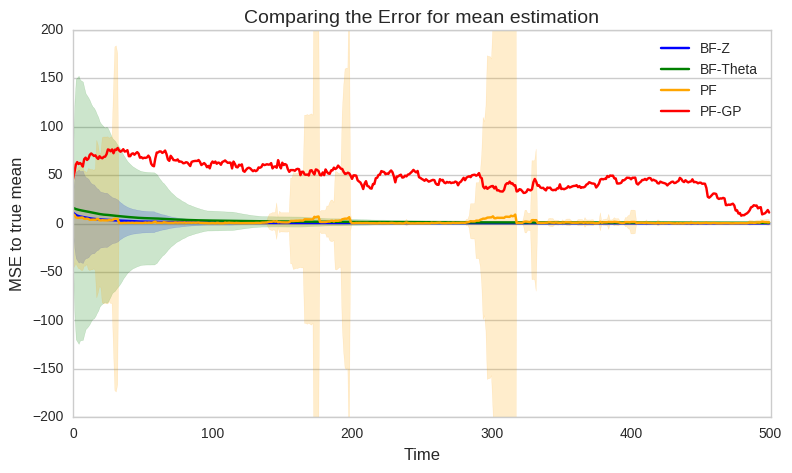

In [22]:
def mseMeanPlot():
    plt.figure(figsize=(9,5))
    plt.plot(range(len(mmA)), mmA, label="BF-Z", color='b')
    plt.fill_between(range(len(mmA)), mmA-vmA, mmA+vmA, alpha=0.2, color='b')
    plt.plot(range(len(mmO)), mmO, label="BF-Theta", color='g')
    plt.fill_between(range(len(mmO)), mmO-vmO, mmO+vmO, alpha=0.2, color='g')
    plt.plot(range(len(mmPF)), mmPF, label="PF", color='orange')
    plt.fill_between(range(len(mmPF)), mmPF-vmPF, mmPF+vmPF, alpha=0.2, color='orange')
    plt.plot(range(len(mmPFGP)), mmPFGP, label="PF-GP", color='red')
    #plt.fill_between(range(len(mmPFGP)), mmPFGP-vmPFGP, mmPFGP+vmPFGP, alpha=0.2, color='red')
    plt.legend()
    plt.ylim(-200,200)

    plt.ylabel('MSE to true mean', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    #plt.ylim(-0.1,1.1)
    plt.axes().xaxis.grid(False)
    plt.title('Comparing the Error for mean estimation',  fontsize=14)

    plt.show()

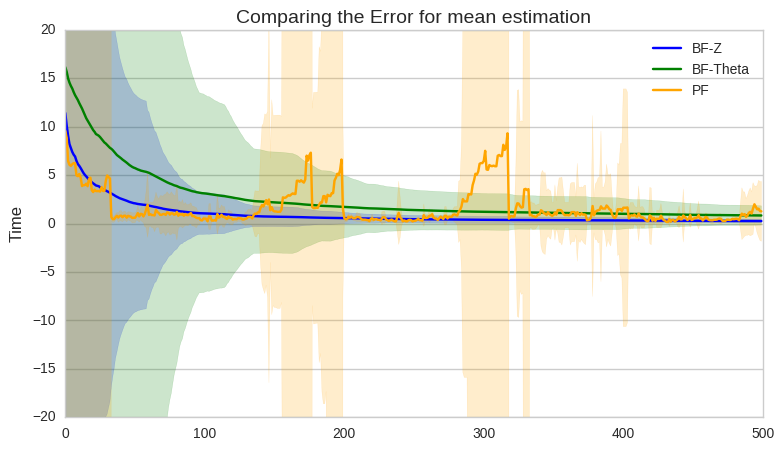

In [17]:
def mseMeanPlotZoom():
    plt.figure(figsize=(9,5))
    plt.plot(range(len(mmA)), mmA, label="BF-Z", color='b')
    plt.fill_between(range(len(mmA)), mmA-vmA, mmA+vmA, alpha=0.2, color='b')
    plt.plot(range(len(mmO)), mmO, label="BF-Theta", color='g')
    plt.fill_between(range(len(mmO)), mmO-vmO, mmO+vmO, alpha=0.2, color='g')
    plt.plot(range(len(mmPF)), mmPF, label="PF", color='orange')
    plt.fill_between(range(len(mmPF)), mmPF-vmPF, mmPF+vmPF, alpha=0.2, color='orange')
    #plt.plot(range(len(mmPFGP)), mmPFGP, label="PF-GP", color='red')
    #plt.fill_between(range(len(mmPFGP)), mmPFGP-vmPFGP, mmPFGP+vmPFGP, alpha=0.2, color='red')
    plt.legend()
    plt.ylim(-20,20)

    plt.ylabel('MSE to true mean', fontsize=12)
    plt.ylabel('Time', fontsize=12)
    #plt.ylim(-0.1,1.1)
    plt.axes().xaxis.grid(False)
    plt.title('Comparing the Error for mean estimation',  fontsize=14)

    plt.show()

### Experiment 2. Wrong number of States

In [21]:
def plotMultiStateParticleState(data, z, m, v, cp, trueCP):
    f, axarr = plt.subplots(2, sharex=True, figsize=(9, 3))
    axarr[0].set_xlim([-10,len(data)+10])
################ PREPARE DATA ################     
    states = len(z[0])
    zData = []
    meanData = []
    varData = []
    for i in range(states):
        zData.append(([],range(len(data))))
        meanData.append(([],range(len(data))))
        varData.append(([],range(len(data))))
    for t,z_t in enumerate(z):
        if len(z_t)>states:
            states += 1
            zData.append(([],range(t,len(data))))
            meanData.append(([],range(t,len(data))))
            varData.append(([],range(t,len(data))))
        for i,z_t_i in enumerate(z_t):
            zData[i][0].append(z_t_i)
            meanData[i][0].append(m[t][i])
            varData[i][0].append(v[t][i])
################ PLOT MEAN AND VAR################      
    for m, v in zip(meanData, varData):
        axarr[0].plot(m[1][:len(m[0])], m[0])
    axarr[0].set_title("Estimated Means")
    axarr[0].set_ylim(min(data)-17, max(data)+17)
    axarr[0].scatter(range(0,len(data)), data, marker='x', color='red')
################ PLOT Z ################ 
    for z in zData:
        axarr[1].plot(z[1][:len(z[0])], z[0])
    axarr[1].set_ylim([-0.2,1.2])
    axarr[1].set_title("State Probability")
    axarr[1].set_yticks((0,0.5,1))


    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [20]:
data3, tcp3 = GaussianTestData(mean=[-5,5,10], var=[1,1,1], l=500)
data5, tcp5 = GaussianTestData(mean=[-5,5,10,-7,0], var=[1,1,1,1,1], l=500)
data8, tcp8 = GaussianTestData(mean=[-5,5,10,-7,0,16,20,-12], var=[1,1,1,1,1,1,1,1], l=500)

In [18]:
M3 = np.matrix([[0.9, 0.05, 0.05],\
                [0.05, 0.9, 0.05],\
                [0.05, 0.05, 0.9]])

M5 = np.matrix([[0.9, 0.025, 0.025, 0.025, 0.025],\
                [0.025, 0.9, 0.025, 0.025, 0.025],\
                [0.025, 0.025, 0.9, 0.025, 0.025],\
                [0.025, 0.025, 0.025, 0.9, 0.025],\
                [0.025, 0.025, 0.025, 0.025, 0.9]])


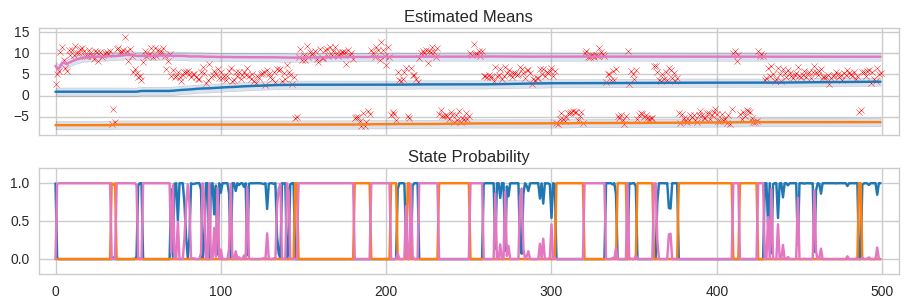

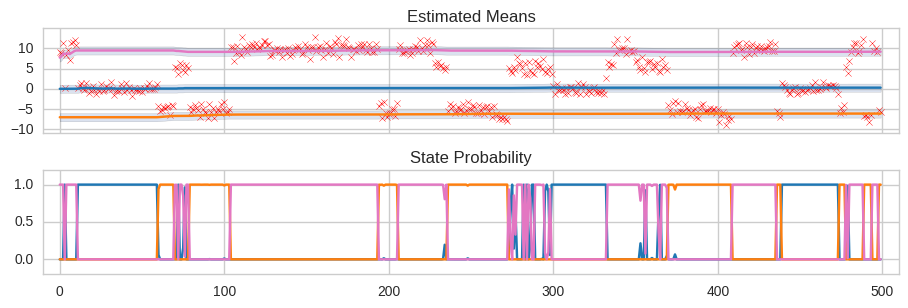

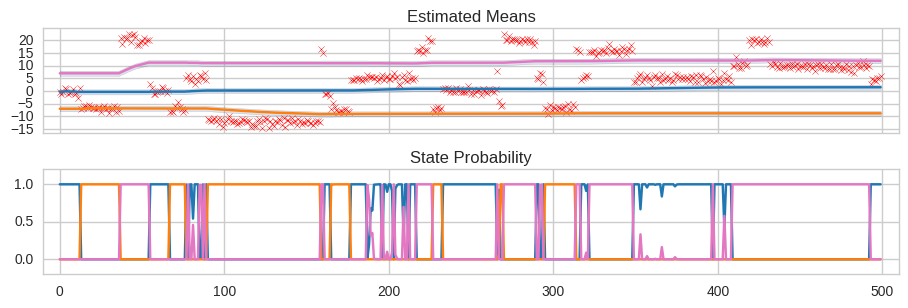

In [125]:
f = AndreasBayesFilterSOFT(3,M3, means = [0,-7,7])
z1,m1,v1, cp1 = f.run(data3)
plotMultiStateParticleState(data3, z1, m1, v1, cp1, tcp3)
f = AndreasBayesFilterSOFT(3,M3, means = [0,-7,7])
z1,m1,v1, cp1 = f.run(data5)
plotMultiStateParticleState(data5, z1, m1, v1, cp1, tcp5)
f = AndreasBayesFilterSOFT(3,M3, means = [0,-7,7])
z1,m1,v1, cp1 = f.run(data8)
plotMultiStateParticleState(data8, z1, m1, v1, cp1, tcp8)

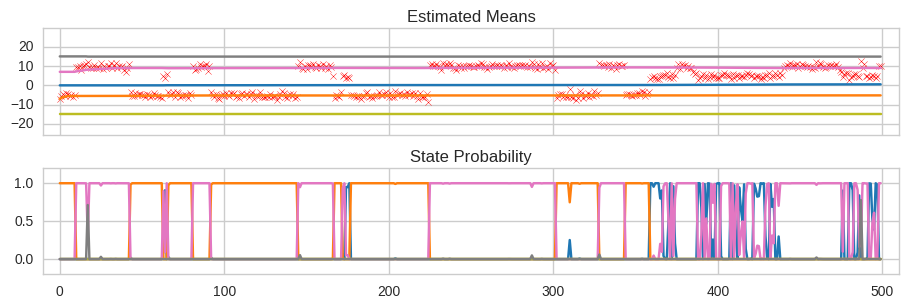

In [22]:
f = AndreasBayesFilterSOFT(5,M5, means = [0,-7,7,-15,15])
z1,m1,v1, cp1 = f.run(data3)
plotMultiStateParticleState(data3, z1, m1, v1, cp1, tcp3)
#f = AndreasBayesFilterSOFT(5,M5, means = [0,-7,7,-15,15])
#z1,m1,v1, cp1 = f.run(data5)
#plotMultiStateParticleState(data5, z1, m1, v1, cp1, tcp5)
#f = AndreasBayesFilterSOFT(5,M5, means = [0,-7,7,-15,15])
#z1,m1,v1, cp1 = f.run(data8)
#plotMultiStateParticleState(data8, z1, m1, v1, cp1, tcp8)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


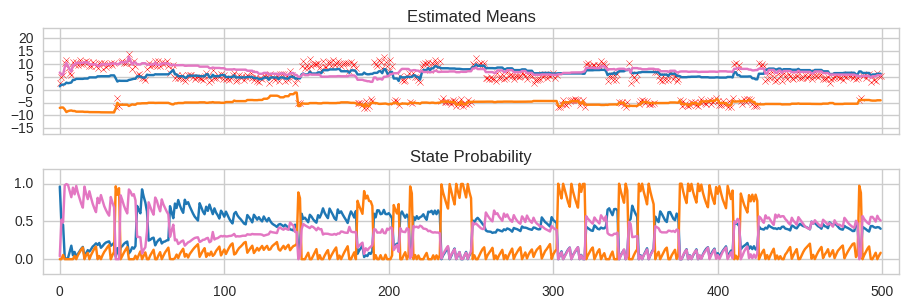

In [134]:
f = BootstrapFilterOpperMultiState(prior=[0,-7,7], N=2000)
z1,m1,v1, cp1 = f.run(data3)
plotMultiStateParticleState(data3, z1, m1, v1, cp1, tcp3)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


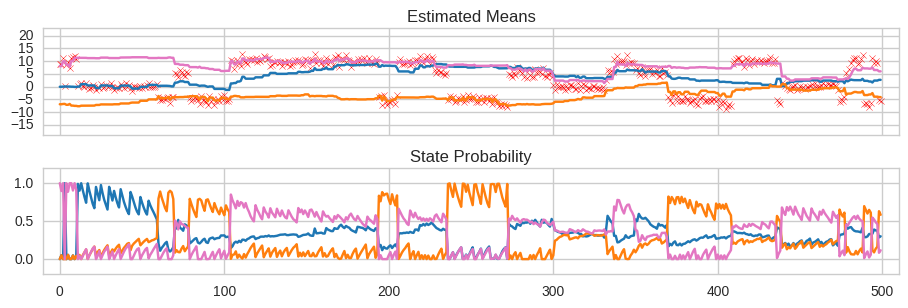

In [135]:
f = BootstrapFilterOpperMultiState(prior=[0,-7,7], N=2000)
z1,m1,v1, cp1 = f.run(data5)
plotMultiStateParticleState(data5, z1, m1, v1, cp1, tcp5)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


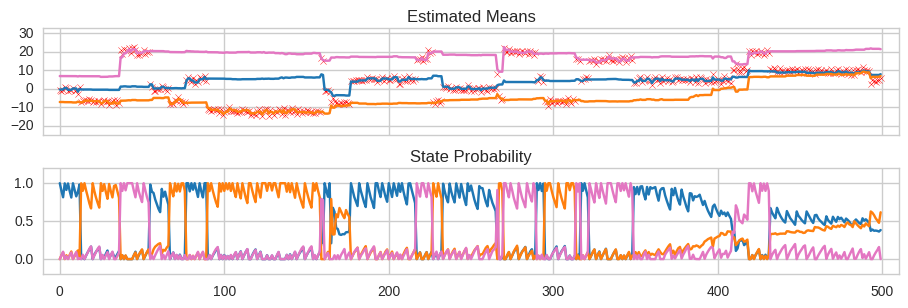

In [136]:
f = BootstrapFilterOpperMultiState(prior=[0,-7,7], N=2000)
z1,m1,v1, cp1 = f.run(data8)
plotMultiStateParticleState(data8, z1, m1, v1, cp1, tcp8)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


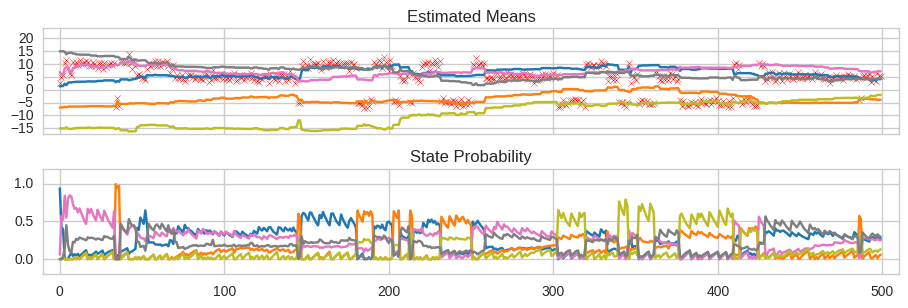

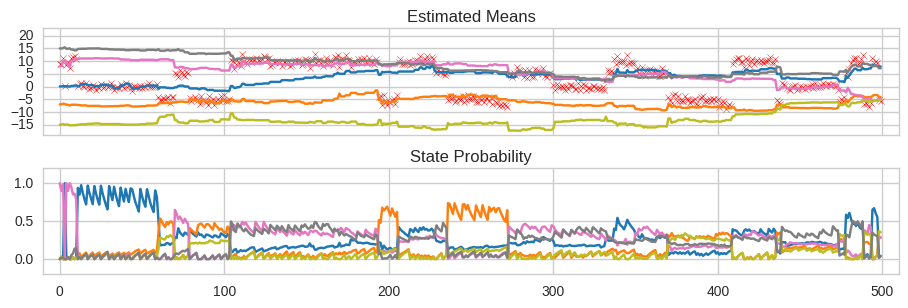

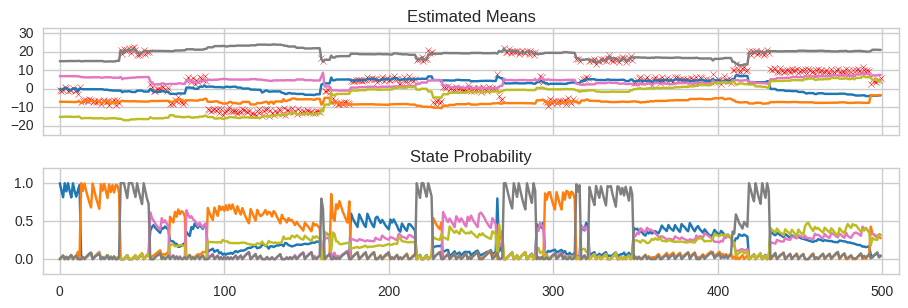

In [137]:
f = BootstrapFilterOpperMultiState(prior=[0,-7,7,-15,15], N=2000)
z1,m1,v1, cp1 = f.run(data3)
plotMultiStateParticleState(data3, z1, m1, v1, cp1, tcp3)
f = BootstrapFilterOpperMultiState(prior=[0,-7,7,-15,15], N=2000)
z1,m1,v1, cp1 = f.run(data5)
plotMultiStateParticleState(data5, z1, m1, v1, cp1, tcp5)
f = BootstrapFilterOpperMultiState(prior=[0,-7,7,-15,15], N=2000)
z1,m1,v1, cp1 = f.run(data8)
plotMultiStateParticleState(data8, z1, m1, v1, cp1, tcp8)

## Change Point Detection

### Algorithms

In [36]:
from numpy.random import gamma, randn, rand
from scipy.special import gammaln

### Change Point Detection by Adams and MacKay

In [37]:
class BaysianChangepointDetector():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.):
        self.mu0    = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0  = np.array([beta0])

        self.muT    = np.array([mu0])
        self.kappaT = np.array([kappa0])
        self.alphaT = np.array([alpha0])
        self.betaT  = np.array([beta0])

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0

    def add_data(self, data):

        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.muT,
                               self.betaT*(self.kappaT+1)/(self.alphaT*self.kappaT),
                               2 * self.alphaT)

        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)

        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                            * predictive * hazard).sum()

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()
        #print data, predictive, self.beliefs[:,self.runlength+1]
        #8. Update parameters
        muT0    = np.concatenate([self.mu0, (self.kappaT*self.muT + data) / (self.kappaT+1)])
        kappaT0 = np.concatenate([self.kappa0, self.kappaT + 1])
        alphaT0 = np.concatenate([self.alpha0, self.alphaT + 0.5])
        betaT0  = np.concatenate([self.beta0, self.kappaT + (self.kappaT*(data-self.muT)**2)
                                  / (2*(self.kappaT+1))])
        self.muT     = muT0
        self.kappaT  = kappaT0
        self.alphaT  = alphaT0
        self.betaT   = betaT0
        
        #9. not implemented, we don't want to make predictions for the next datum

        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums


    def __compute_predictive(self, data, mu, var, nu):
        r = np.asarray(nu*1.0)
        c = np.exp(gammaln((r+1)/2) - gammaln(r/2))
        c /= np.sqrt(r * np.pi * var) * (1+((data-mu)**2)/(r*var))**((r+1)/2)
        return c

    def __compute_hazard(self):
        _lambda = 250
        probability = np.ones(1) / _lambda
        return probability

### Change Point Detection with perfect knowledge of two states

In [38]:
class BaysianChangepointDetector2Prior():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1., prior=[10,4]):
        self.mu0    = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0  = np.array([beta0])

        self.muT    = np.array([mu0])
        self.kappaT = np.array([kappa0])
        self.alphaT = np.array([alpha0])
        self.betaT  = np.array([beta0])
        
        self.mu = np.zeros(1)
        self.var =1
        self.prior = prior

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0
        
        self.currState = -1

    def add_data(self, data):        
        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.muT,
                               self.betaT*(self.kappaT+1)/(self.alphaT*self.kappaT),
                               2 * self.alphaT)
        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)        
        
        z = np.zeros(2)       
        z[0] = scipy.stats.norm(self.prior[0],1).pdf(data)
        z[1] = scipy.stats.norm(self.prior[1],1).pdf(data)
        if self.currState == np.argmax(z):
            self.currState = np.argmax(z)
            z=np.zeros(2)
        else:
            self.currState = np.argmax(z)
        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                           * predictive * hazard).sum() + (z.max() * hazard)
        
        newMu = np.zeros(1)
        #if we belief its a change point
        if np.argmax(self.beliefs[:,self.runlength+1]) == 0:
            if (self.beliefs[0:self.runlength+1,self.runlength] * predictive * hazard).sum() < z.max():
                newMu[0] = self.prior[np.argmax(z)]                                           

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()

        #8. Update parameters
        mu = 1.0/(1.0/1 + 1) *(data + self.mu/1)
        self.mu = np.concatenate([newMu, mu])
        #8. Update parameters
        muT0    = np.concatenate([newMu, (self.kappaT*self.muT + data) / (self.kappaT+1)])
        kappaT0 = np.concatenate([self.kappa0, self.kappaT + 1])
        alphaT0 = np.concatenate([self.alpha0, self.alphaT + 0.5])
        betaT0  = np.concatenate([self.beta0, self.kappaT + (self.kappaT*(data-self.muT)**2)
                                  / (2*(self.kappaT+1))])
        self.muT     = muT0
        self.kappaT  = kappaT0
        self.alphaT  = alphaT0
        self.betaT   = betaT0

        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums
    
    def __computeTheta(self, _x, _mu, _var, _z):
        var = 1.0/(1.0/_var + 1)
        mu = 1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        return mu

    def __compute_predictive(self, data, mu, var, nu):
        r = np.asarray(nu*1.0)
        c = np.exp(gammaln((r+1)/2) - gammaln(r/2))
        c /= np.sqrt(r * np.pi * var) * (1+((data-mu)**2)/(r*var))**((r+1)/2)
        return c

    def __compute_hazard(self):
        _lambda = 20
        probability = np.ones(1) / _lambda
        return probability
    


### Change Point Detection with a given Bayes Filter

In [39]:
class BaysianChangepointDetectorGaussFilter():

    def __init__(self, mu0 = 0., kappa0 = 1., alpha0 = 1., beta0 = 1.,\
                 filter=AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[11,3])):
        self.mu0    = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0  = np.array([beta0])

        self.muT    = np.array([mu0])
        self.kappaT = np.array([kappa0])
        self.alphaT = np.array([alpha0])
        self.betaT  = np.array([beta0])
        
        self.mu = np.zeros(1)
        self.var =1

        self.beliefs = np.array([[1],[0]])
        self.maximums = []
        self.runlength = 0
        
        self.filter = filter

    def add_data(self, data):        
        self.filter.update(data)
        
        #extend the datastructure of beliefs
        self.beliefs = np.append(self.beliefs, [np.zeros(self.beliefs.shape[1])],0)
        self.beliefs = np.append(self.beliefs, np.zeros(self.beliefs.shape[0])[np.newaxis].T,1)

        #compute hazard
        hazard = self.__compute_hazard()

        #3. Evaluate Predictive probability for new datum
        predictive = self.__compute_predictive(data, self.muT,
                               self.betaT*(self.kappaT+1)/(self.alphaT*self.kappaT),
                               2 * self.alphaT)
        #4.Calculate Growth probabilities
        self.beliefs[1:self.runlength+2,self.runlength+1] = self.beliefs[0:self.runlength+1,self.runlength]\
                                                            * predictive * (1-hazard)
        filterMean = self.filter.getBCPinfo()
        
        filterProb = scipy.stats.norm(filterMean,1).pdf(data)
                
        #5. Calculate Changepoint probabilities
        self.beliefs[0,self.runlength+1] = (self.beliefs[0:self.runlength+1,self.runlength]
                                           * predictive * hazard).sum() + (filterProb * hazard)
        
        newMu = np.zeros(1)
        #if we belief its a change point
        if np.argmax(self.beliefs[:,self.runlength+1]) == 0:
            #if the prior state is more likely then just a new state
            if (self.beliefs[0:self.runlength+1,self.runlength] * predictive * hazard).sum() < filterProb:
                newMu[0] = filterMean#set new mu to prior 

        # Renormalize the run length probabilities for improved numerical stability.
        self.beliefs[:,self.runlength+1] = self.beliefs[:,self.runlength+1] / \
                                           self.beliefs[:,self.runlength+1].sum()

        #8. Update parameters
        muT0    = np.concatenate([newMu, (self.kappaT*self.muT + data) / (self.kappaT+1)])
        kappaT0 = np.concatenate([self.kappa0, self.kappaT + 1])
        alphaT0 = np.concatenate([self.alpha0, self.alphaT + 0.5])
        betaT0  = np.concatenate([self.beta0, self.kappaT + (self.kappaT*(data-self.muT)**2)
                                  / (2*(self.kappaT+1))])
        self.muT     = muT0
        self.kappaT  = kappaT0
        self.alphaT  = alphaT0
        self.betaT   = betaT0
        
        self.maximums.append(np.where(self.beliefs[:,self.runlength]==self.beliefs[:,self.runlength].max())[0][0])
        self.runlength += 1
        return self.beliefs, self.maximums
    
    def __computeTheta(self, _x, _mu, _var, _z):
        #compute updated var
        var = 1.0/(1.0/_var + 1)
        #compute updated mean
        mu = 1.0/(1.0/_var + _z) * (_z*_x + _mu/_var)
        #return mu,var      
        return mu

    def __compute_predictive(self, data, mu, var, nu):
        r = np.asarray(nu*1.0)
        c = np.exp(gammaln((r+1)/2) - gammaln(r/2))
        c /= np.sqrt(r * np.pi * var) * (1+((data-mu)**2)/(r*var))**((r+1)/2)
        return c

    def __compute_hazard(self):
        _lambda = 20
        probability = np.ones(1) / _lambda
        return probability

## Change Point Detection evaluation

In [40]:
def infereCP(maxima, adams=False):
    prevM = -1
    cp = []
    for i,m in enumerate(maxima):
        if(m<prevM):
            cp.append(i-(m))
        prevM=m
    if adams:
        return [x+1 for x in cp]
    return cp

### Visual evaluation

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [42]:
def CPDsubplot(d, beliefs, maxRunLength, cp, trueCP):
    f, axarr = plt.subplots(3, sharex=True, figsize=(9, 6))
    #axarr[0].set_xlim([-10,len(data)+10])
    axarr[0].set_title('Data')
    axarr[0].plot(range(len(d)),d, 'r.')

    axarr[1].set_title('Belief in run length')
    im = axarr[1].imshow(beliefs[:maxRunLength+4,:],origin='lower', cmap='hot_r',  interpolation='nearest', aspect='auto')
    cbaxes = inset_axes(axarr[1], width="20%", height="7%", loc=2) 
    plt.colorbar(im,cax=cbaxes, ticks=[0.,0.5,1], orientation='horizontal')

    for p in cp:
        axarr[2].axvline(x=p-1, ymin=0, ymax = 0.5, color='red', alpha=1.0)
    for p in trueCP:
        axarr[2].axvline(x=p-1, ymin=0.5, ymax = 1, color='green', alpha=1.0)
    axarr[2].axvline(x=cp[0]-1, ymin=0, ymax = 0.5, color='red', alpha=1.0, label='Prediction')
    axarr[2].axvline(x=trueCP[0]-1, ymin=0.5, ymax = 1, color='green', alpha=1.0, label='Truth')
    axarr[2].grid(axis='y')
    axarr[2].set_yticks(())
    axarr[2].set_title("Predicted Change Points")
    axarr[2].legend(frameon=True, framealpha=0.6)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

In [51]:
d,trueCP = GaussianTestData(mean=[5,0], var=[1,1], l=100)
print trueCP

[5, 6, 13, 37, 75, 79, 87]


In [52]:
bcp = BaysianChangepointDetector()
bcp2 = BaysianChangepointDetector2Prior(prior=[0,5])
bcp3 = BaysianChangepointDetectorGaussFilter(filter=AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[-1,8]))
for i in d:
    bcp.add_data(i)
    bcp2.add_data(i)
    bcp3.add_data(i)

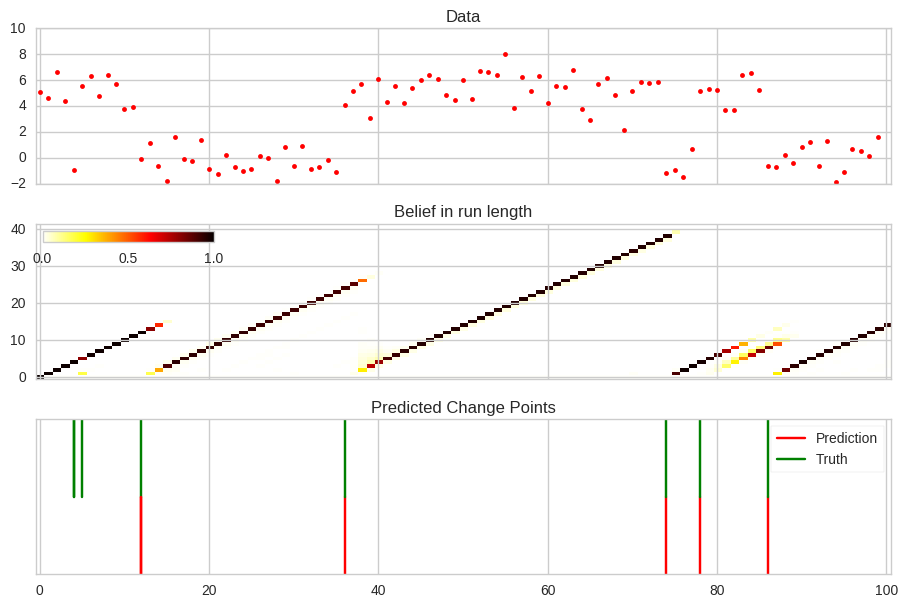

In [53]:
CPDsubplot(d, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums, adams=True), trueCP)

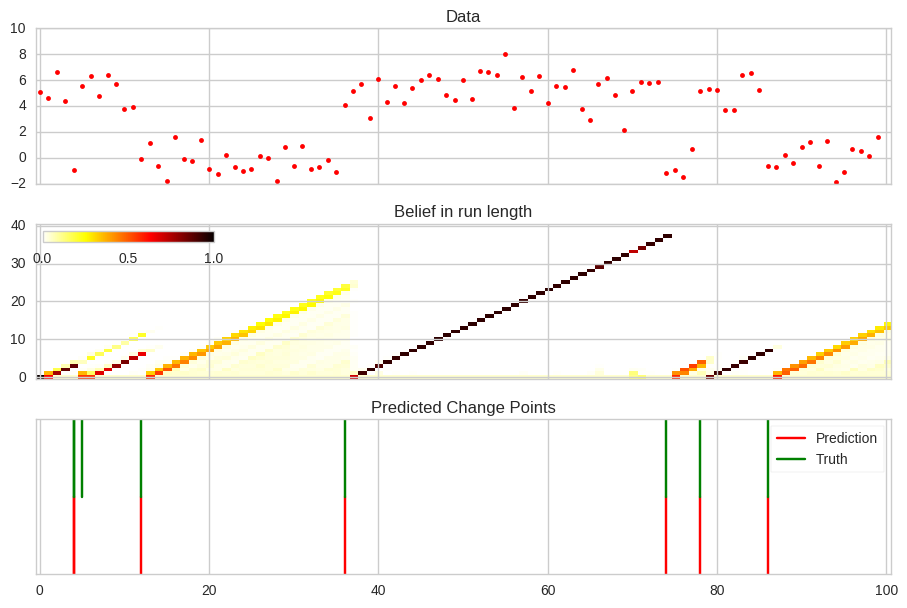

In [54]:
CPDsubplot(d, bcp2.beliefs, max(bcp2.maximums), infereCP(bcp2.maximums), trueCP)

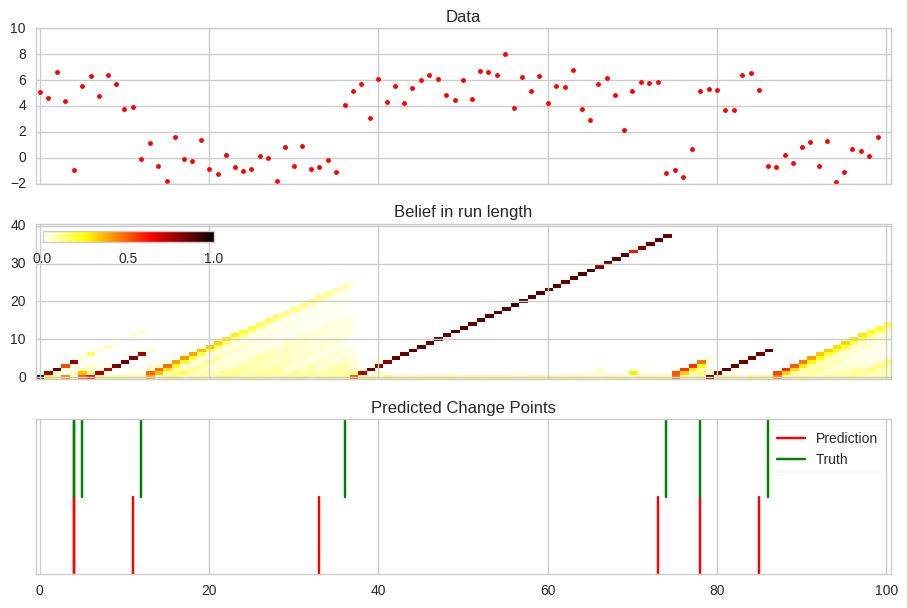

In [55]:
CPDsubplot(d, bcp3.beliefs, max(bcp3.maximums), infereCP(bcp3.maximums), trueCP)

### f1-score

In [18]:
def f1score(estimatedCP, trueCP):
    correctPredictions = 0
    for cp in trueCP:
        if cp in estimatedCP:
            correctPredictions += 1.0
        else:
            cpRange = range(cp-5,cp+5)
            for cpR in cpRange:
                if cpR in estimatedCP:
                    #pass
                    correctPredictions += 0.5
    f1 = 0
    try:
        precision = correctPredictions/len(estimatedCP)
        recall = correctPredictions/len(trueCP)
        f1 = 2.0*(precision*recall)/(precision+recall)
    except:
        f1 = 0
        #print 'no change point'
    #print 'F1:', f1
    return f1

In [784]:
d,trueCP = GaussianTestData(mean=[5,9], l=100)
bcp = BaysianChangepointDetector()
bcp1 = BaysianChangepointDetector2Prior(prior=[5,9])
bcp2 = BaysianChangepointDetectorGaussFilter(filter=AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[10,4]))
bcp3 = BaysianChangepointDetectorGaussFilter(filter=BayesFilter(mean=[4,10]))
bcp4 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiState(prior=[4,10]))
bcp5 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiStateGammaPi(prior=[4,10]))

for i in d:
    bcp.add_data(i)
    bcp1.add_data(i)
    bcp2.add_data(i)
    bcp3.add_data(i)
    bcp4.add_data(i)
    bcp5.add_data(i)
    
f1score(infereCP(bcp.maximums, adams=True), trueCP)
f1score(infereCP(bcp1.maximums), trueCP)
f1score(infereCP(bcp2.maximums), trueCP)
f1score(infereCP(bcp3.maximums), trueCP)
f1score(infereCP(bcp4.maximums), trueCP)
f1score(infereCP(bcp5.maximums), trueCP)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


F1: 0.625
F1: 0.888888888889
F1: 0.888888888889
F1: 0.888888888889
F1: 0.888888888889
F1: 0.8


0.8000000000000002

In [874]:
bcpf1 = []
bcp1f1 = []
bcp2f1 = []
bcp3f1 = []
bcp4f1 = []
bcp5f1 = []

bcpdt = []
bcp1dt = []
bcp2dt = []
bcp3dt = []
bcp4dt = []
bcp5dt = []
for a in range(10):
    d,trueCP = GaussianTestData(mean=[5,9], l=100)
    bcp = BaysianChangepointDetector()
    bcp1 = BaysianChangepointDetector2Prior(prior=[5,9])
    bcp2 = BaysianChangepointDetectorGaussFilter(filter=AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[10,4]))
    bcp3 = BaysianChangepointDetectorGaussFilter(filter=BayesFilter(mean=[4,10]))
    bcp4 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiState(prior=[4,10]))
    bcp5 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiStateGammaPi(prior=[4,10]))
    for i in d:
        bcp.add_data(i)
        bcp1.add_data(i)
        bcp2.add_data(i)
        bcp3.add_data(i)
        bcp4.add_data(i)
        bcp5.add_data(i)
    bcpf1.append(f1score(infereCP(bcp.maximums, adams=True), trueCP))
    bcp1f1.append(f1score(infereCP(bcp1.maximums), trueCP))
    bcp2f1.append(f1score(infereCP(bcp2.maximums), trueCP))
    bcp3f1.append(f1score(infereCP(bcp3.maximums), trueCP))
    bcp4f1.append(f1score(infereCP(bcp4.maximums), trueCP))
    bcp5f1.append(f1score(infereCP(bcp5.maximums), trueCP))
    
    bcpdt.append(detectionTimes(bcp.maximums, adams=True))
    bcp1dt.append(detectionTimes(bcp1.maximums))
    bcp2dt.append(detectionTimes(bcp2.maximums))
    bcp3dt.append(detectionTimes(bcp3.maximums))
    bcp4dt.append(detectionTimes(bcp4.maximums))
    bcp5dt.append(detectionTimes(bcp5.maximums))

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


no change point


In [917]:
f1 = [bcpf1, bcp1f1, bcp2f1, bcp3f1, bcp4f1, bcp5f1]
dt = [bcpdt, bcp1dt, bcp2dt, bcp3dt, bcp4dt, bcp5dt]
with open('bcpResults.pickle', 'a') as f:
    pickle.dump((f1,dt), f)

In [196]:
f1 = []
dt = []
with open('bcpResults.pickle', 'rb') as f:
        f1,dt = pickle.load(f)

In [201]:
print dt

[[[37, 26, 3, 5], [7, 0, 6], [], [2], [6, 3, 7, 7], [14, 2], [3, 6], [7, 1], [12, 3, 5], [3]], [[0, 1, 3, 0, 15, 0, 0], [0, 1, 7, 0, 0], [1, 0, 3, 0, 1, 0, 0], [0, 0, 0, 0, 9, 13], [0, 3, 0, 0, 0], [0, 1, 4, 0, 0, 0, 0], [0], [2, 0, 0], [0, 0, 0, 0, 0, 0], [0]], [[0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 2, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0], [0, 0, 0], [0, 0, 0, 0, 0], [0]], [[0, 2, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 2, 0], [0, 1, 0, 0, 0, 0, 0, 0, 8, 0], [0], [0, 0, 0], [0, 0, 0, 0, 0], [0]], [[0, 0, 0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1], [0, 3, 0, 0, 2, 4], [0, 0, 0, 0, 28, 0, 0], [1], [0, 0, 1, 0, 0, 8, 16], [0, 0, 0, 0, 0, 0], [0]], [[0, 1, 3, 0, 1, 3, 0], [0, 1, 0, 0, 1], [1, 0, 3, 0, 0], [0, 0, 0, 1], [0, 0, 3, 0, 4], [0, 1, 0, 7, 5, 0, 0, 0], [1], [3, 0, 1, 0], [0, 0, 0, 0, 0, 3, 7, 4], [0]]]


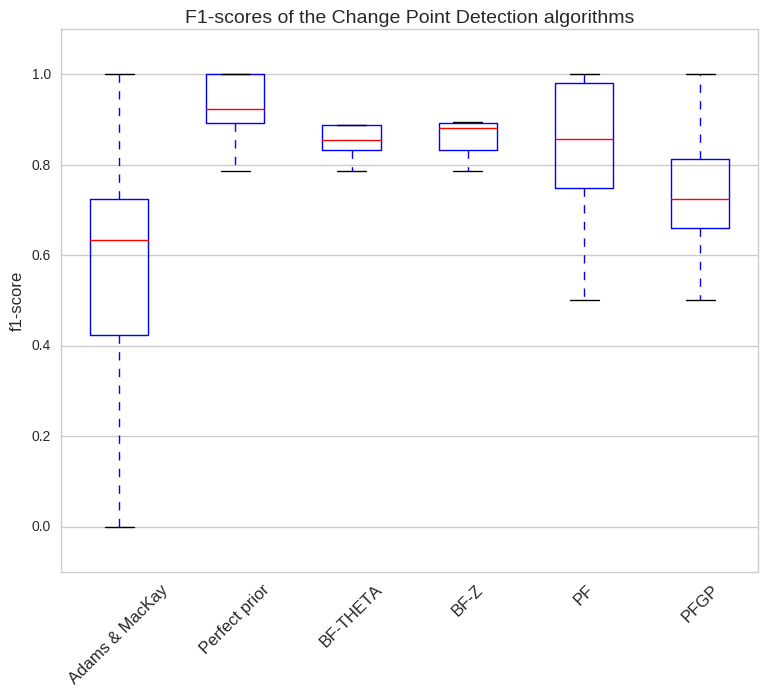

In [198]:
algoNames = ['Adams & MacKay', "Perfect prior", "BF-THETA", "BF-Z", "PF", "PFGP"]
boxData = f1
plt.figure(figsize=(9,7))
bp = plt.boxplot(boxData)
plt.ylabel('f1-score', fontsize=12)
plt.xticks([1,2,3,4,5,6],algoNames,rotation=45, fontsize=12)
plt.ylim(-0.1,1.1)
plt.axes().xaxis.grid(False)
plt.title('F1-scores of the Change Point Detection algorithms',  fontsize=14)

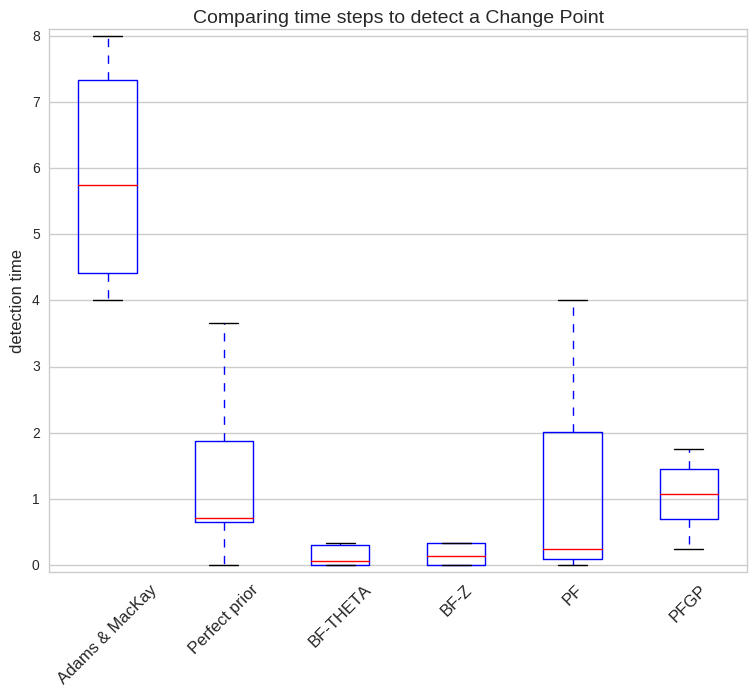

In [202]:
boxData = []
for algo in dt:
    ml = []
    for x in algo:
        if len(x)>1:
            m = np.mean(x)
            ml.append(m)
    boxData.append(ml)

algoNames = ['Adams & MacKay', "Perfect prior", "BF-THETA", "BF-Z", "PF", "PFGP"]
plt.figure(figsize=(9,7))
bp = plt.boxplot(boxData)
plt.ylabel('detection time', fontsize=12)
plt.xticks([1,2,3,4,5,6],algoNames,rotation=45, fontsize=12)
plt.ylim(-0.1,8.1)
plt.axes().xaxis.grid(False)
plt.title("Comparing time steps to detect a Change Point", fontsize=14)

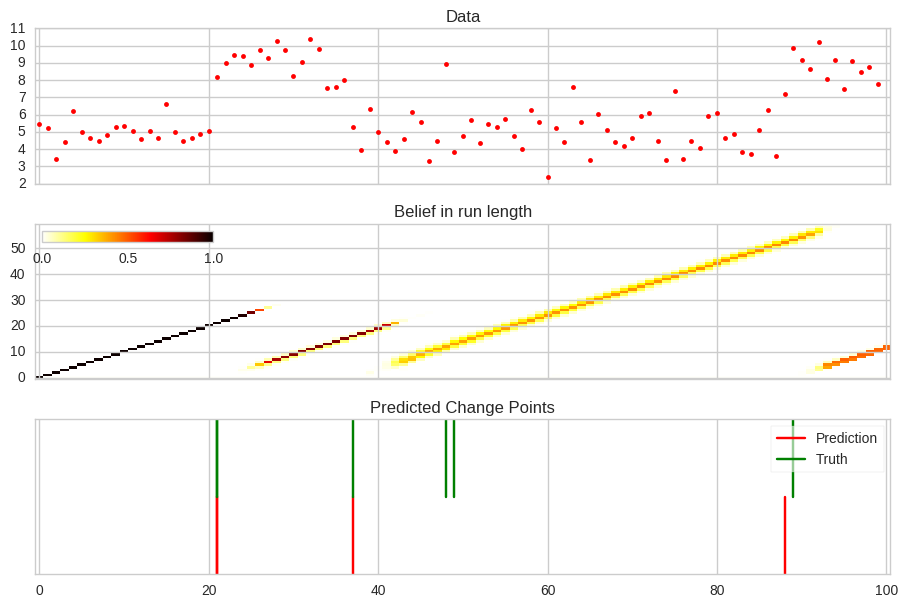

In [786]:
CPDsubplot(d, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums, adams=True), trueCP)

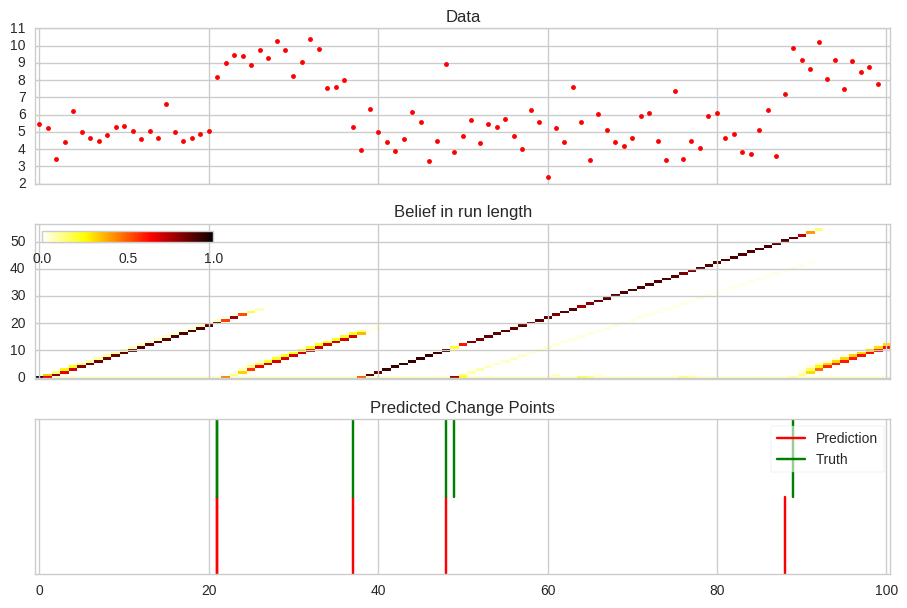

In [787]:
CPDsubplot(d, bcp1.beliefs, max(bcp1.maximums), infereCP(bcp1.maximums), trueCP)

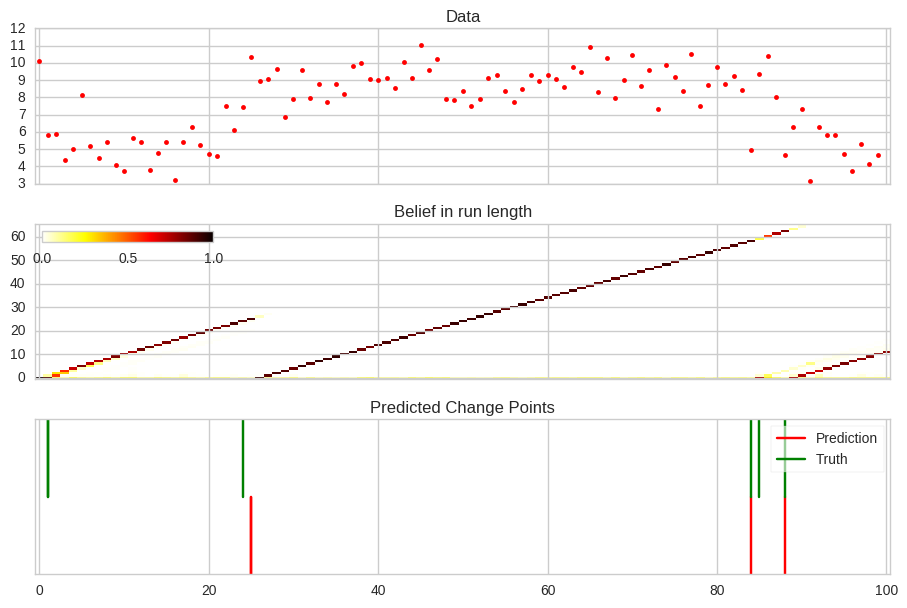

In [722]:
CPDsubplot(d, bcp2.beliefs, max(bcp2.maximums), infereCP(bcp2.maximums), trueCP)

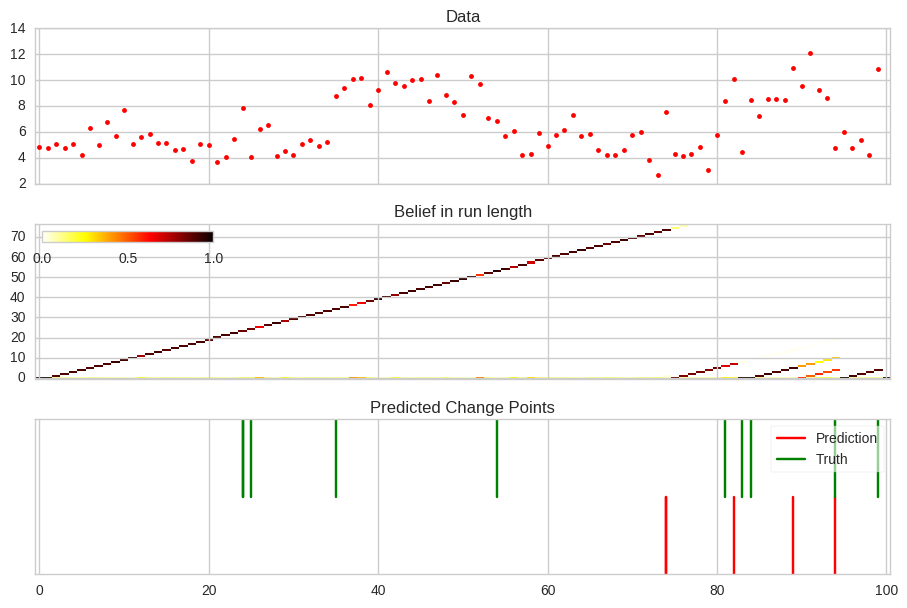

In [695]:
CPDsubplot(d, bcp3.beliefs, max(bcp3.maximums), infereCP(bcp3.maximums), trueCP)

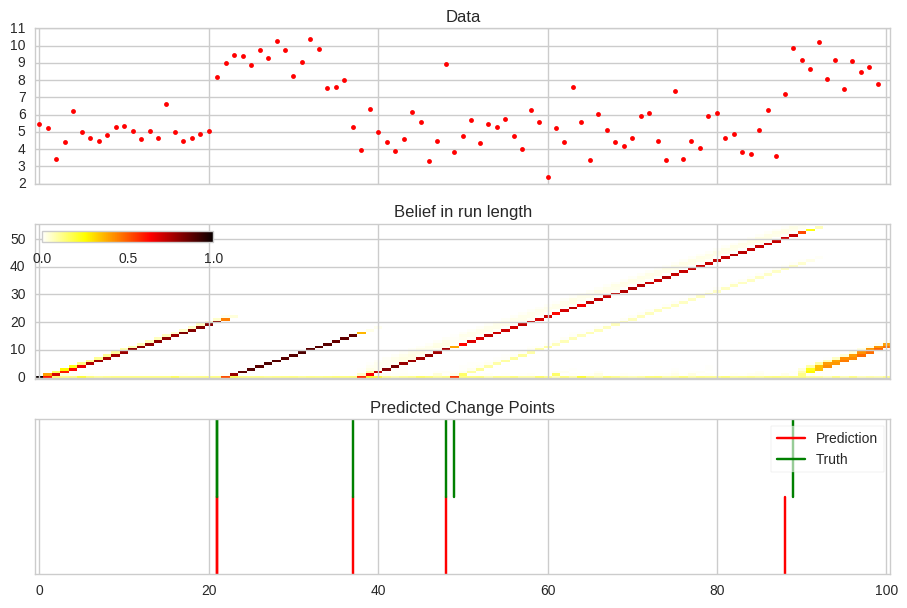

In [789]:
CPDsubplot(d, bcp4.beliefs, max(bcp4.maximums), infereCP(bcp4.maximums), trueCP)

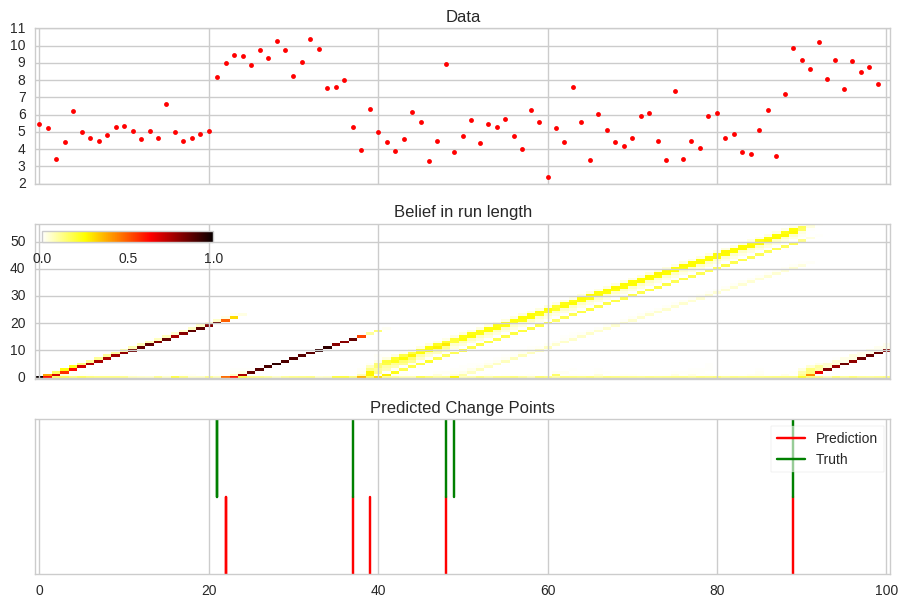

In [788]:
CPDsubplot(d, bcp5.beliefs, max(bcp5.maximums), infereCP(bcp5.maximums), trueCP)

### Time until a change point is detected

In [19]:
def detectionTimes(maxima, adams=False):
    prevM = -1
    l = []
    for i,m in enumerate(maxima):
        if(m<prevM):
            l.append(m)
        prevM=m
    if adams:
        return [x-1 for x in l]
    return l

## F1 score over mean distance

In [21]:
meanDist = [1,1.5,2,2.5,3,3.5,4,4.5,5,6]

bcpf1 = []
bcp1f1 = []
bcp2f1 = []
bcp3f1 = []
bcp4f1 = []
bcp5f1 = []

bcpdt = []
bcp1dt = []
bcp2dt = []
bcp3dt = []
bcp4dt = []
bcp5dt = []
for md in meanDist:
    bcpf1T = []
    bcp1f1T = []
    bcp2f1T = []
    bcp3f1T = []
    bcp4f1T = []
    bcp5f1T = []

    bcpdtT = []
    bcp1dtT = []
    bcp2dtT = []
    bcp3dtT = []
    bcp4dtT = []
    bcp5dtT = []
    for i in range(5):       
        d,trueCP = GaussianTestData(mean=[5,5+md], l=200)
        bcp = BaysianChangepointDetector()
        bcp1 = BaysianChangepointDetector2Prior(prior=[5,5+md])
        bcp2 = BaysianChangepointDetectorGaussFilter(\
                filter=AndreasBayesFilterSOFT(2,np.matrix([[0.9, 0.1],[0.1, 0.9]]), means=[10,4]))
        bcp3 = BaysianChangepointDetectorGaussFilter(filter=BayesFilter(mean=[4,10]))
        bcp4 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiState(prior=[4,10]))
        bcp5 = BaysianChangepointDetectorGaussFilter(filter=BootstrapFilterOpperMultiStateGammaPi(prior=[4,10]))
        for i in d:
            bcp.add_data(i)
            bcp1.add_data(i)
            bcp2.add_data(i)
            bcp3.add_data(i)
            bcp4.add_data(i)
            bcp5.add_data(i)
        bcpf1T.append(f1score(infereCP(bcp.maximums, adams=True), trueCP))
        bcp1f1T.append(f1score(infereCP(bcp1.maximums), trueCP))
        bcp2f1T.append(f1score(infereCP(bcp2.maximums), trueCP))
        bcp3f1T.append(f1score(infereCP(bcp3.maximums), trueCP))
        bcp4f1T.append(f1score(infereCP(bcp4.maximums), trueCP))
        bcp5f1T.append(f1score(infereCP(bcp5.maximums), trueCP))

        bcpdtT.append(detectionTimes(bcp.maximums, adams=True))
        bcp1dtT.append(detectionTimes(bcp1.maximums))
        bcp2dtT.append(detectionTimes(bcp2.maximums))
        bcp3dtT.append(detectionTimes(bcp3.maximums))
        bcp4dtT.append(detectionTimes(bcp4.maximums))
        bcp5dtT.append(detectionTimes(bcp5.maximums))
    bcpf1.append(bcpf1T)
    bcp1f1.append(bcp1f1T)
    bcp2f1.append(bcp2on White Vinegerf1T)
    bcp3f1.append(bcp3f1T)
    bcp4f1.append(bcp4f1T)
    bcp5f1.append(bcp5f1T)

    bcpdt.append(bcpdtT)
    bcp1dt.append(bcp1dtT)
    bcp2dt.append(bcp2dtT)
    bcp3dt.append(bcp3dtT)
    bcp4dt.append(bcp4dtT)
    bcp5dt.append(bcp5dtT)

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [188]:
f1 = [bcpf1, bcp1f1, bcp2f1, bcp3f1, bcp4f1, bcp5f1]
with open('bcpResultsMEanDist-2.pickle', 'a') as f:
    pickle.dump(f1, f)

NameError: name 'bcpf1' is not defined

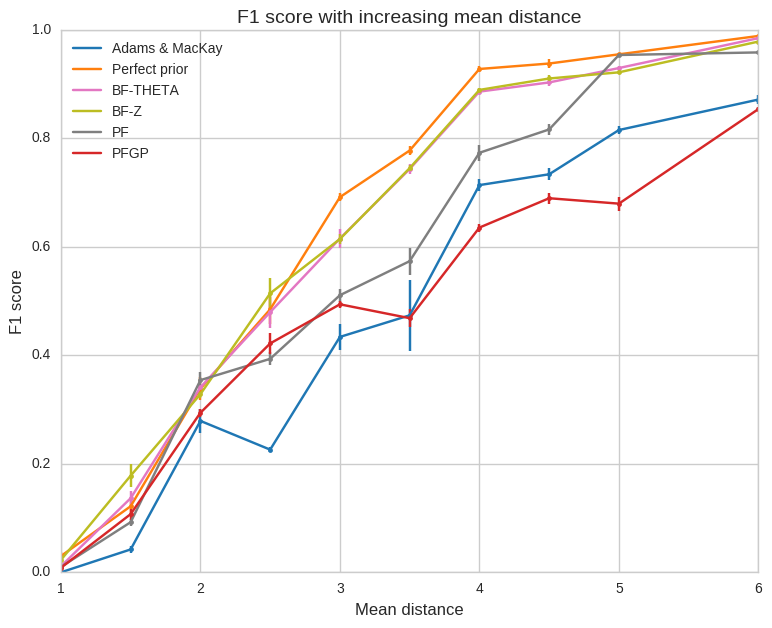

In [190]:
meanDist = [1,1.5,2,2.5,3,3.5,4,4.5,5,6]
f1 = []
with open('bcpResultsMEanDist.pickle', 'rb') as f:
        f1 = pickle.load(f)

d = []
with open('bcpResultsMEanDist-2.pickle', 'rb') as f:
        d = pickle.load(f)
for i,f in enumerate(f1):    
    for j in range(len(f1[i])):
        f1[i][j].extend(d[i][j])
names = ['Adams & MacKay', "Perfect prior", "BF-THETA", "BF-Z", "PF", "PFGP"]
plt.figure(figsize=(9,7))
for c,f in enumerate(f1):
    ml = []
    vl = []
    for i in range(len(meanDist)):
        mean = np.mean(f[i])
        error = np.var(f[i])
        ml.append(mean)
        vl.append(error)
    plt.errorbar(meanDist, ml, yerr=vl, fmt='.',color=colors[c])
    plt.plot(meanDist, ml, color=colors[c], label=names[c])
plt.legend(loc=2)
plt.ylabel('F1 score', fontsize=12)
plt.xlabel('Mean distance', fontsize=12)
plt.title('F1 score with increasing mean distance', fontsize=14)
plt.show()

## Sound example

In [24]:
from scipy import signal
from scipy.io import wavfile

In [161]:
def readPlotWav(filename, xlim):
    f = wavfile.read(filename)
    s_orig_py = np.asarray(f[1],dtype=np.float64)
    f, t, Sxx = signal.spectrogram(s_orig_py, f[0])
    cmap = plt.get_cmap('PiYG')
    #norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    plt.figure(figsize=(4,3))
    plt.pcolormesh(t, f[:20], Sxx[:20], cmap=cmap)
    plt.ylabel('Frequency [Hz]', fontsize=12)
    plt.xlabel('Time [sec]', fontsize=12)
    #plt.ylim(0,2000)
    #plt.xlim(0,xlim)
    plt.show()
    return Sxx

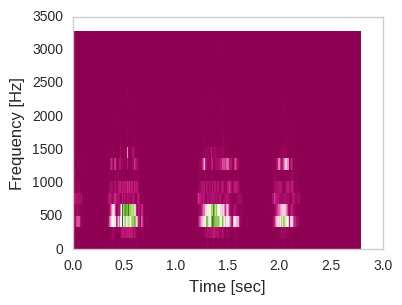

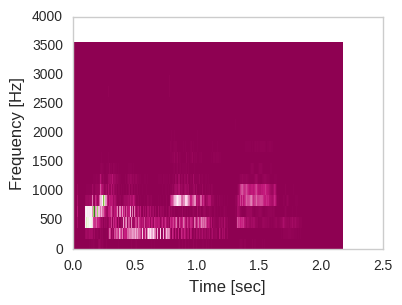

In [162]:
sxxOwl = readPlotWav('dataset/horned_owl-mono.wav',2.5)
sxxJing = readPlotWav('dataset/0564.wav',2.0)

In [72]:
def getMaxfreq(sxx):
    maxFreq = []
    for i in range(np.shape(sxx)[1]):
        maxFreq.append(np.max(sxx[:,i]))
    maxFreq = np.array(maxFreq)
    return (maxFreq / 100000)  + 5

In [163]:
#TODO
#put the maxfreq data into cpd algo
maxOwl = getMaxfreq(sxxOwl)
maxJ = getMaxfreq(sxxJing)

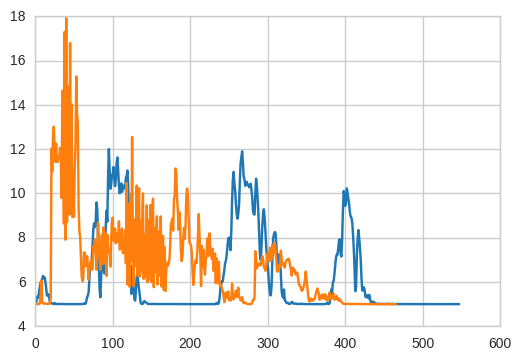

In [164]:
plt.plot(maxOwl)
plt.plot(maxJ)

In [180]:
def CPDsubplotReal(d, beliefs, maxRunLength, cp):
    f, axarr = plt.subplots(2, sharex=True, figsize=(9, 3))

    axarr[0].plot(d)
    for p in cp:
        axarr[0].axvline(x=p-1, color='red', alpha=1.0)    
    axarr[0].axvline(x=cp[0]-1, color='red', alpha=1.0, label='Prediction')
    axarr[0].legend(frameon=True, framealpha=0.6)


    axarr[1].set_title('Belief in run length')
    im = axarr[1].imshow(beliefs[:maxRunLength+4,:],origin='lower', cmap='hot_r',  interpolation='nearest', aspect='auto')
    cbaxes = inset_axes(axarr[1], width="20%", height="7%", loc=2) 
    plt.colorbar(im,cax=cbaxes, ticks=[0.,0.5,1], orientation='horizontal')

    

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

### Jingle

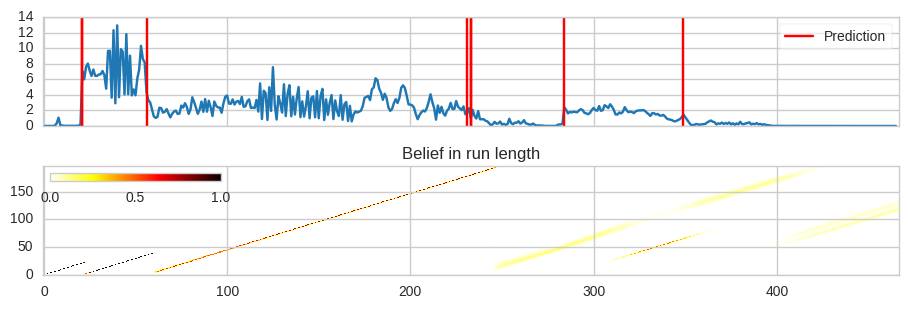

In [181]:
bcp = BaysianChangepointDetector()
for d in maxJ:
    bcp.add_data(d)
CPDsubplotReal(maxJ-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums, adams=True))

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


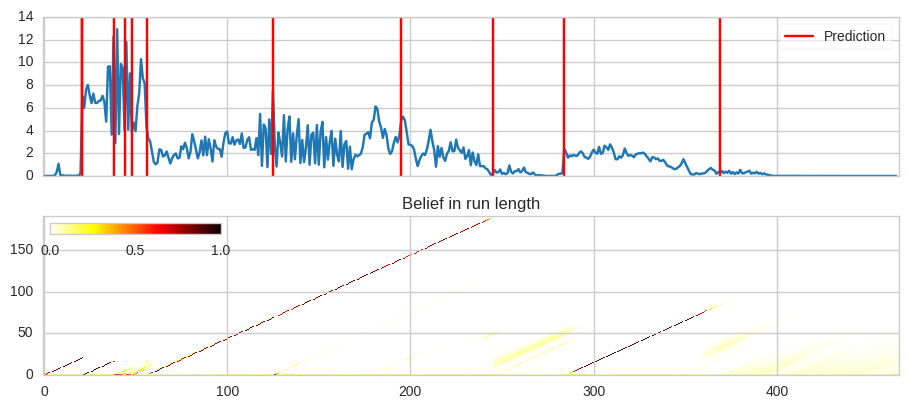

In [174]:
f = BootstrapFilterOpperMultiState(prior=[13,9,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxJ:
    bcp.add_data(d)
CPDsubplotReal(maxJ-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


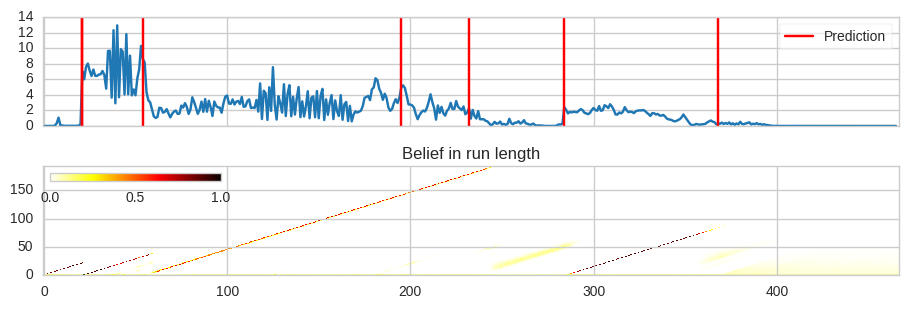

In [182]:
f = BootstrapFilterOpperMultiStateGammaPi(prior=[13,9,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxJ:
    bcp.add_data(d)
CPDsubplotReal(maxJ-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

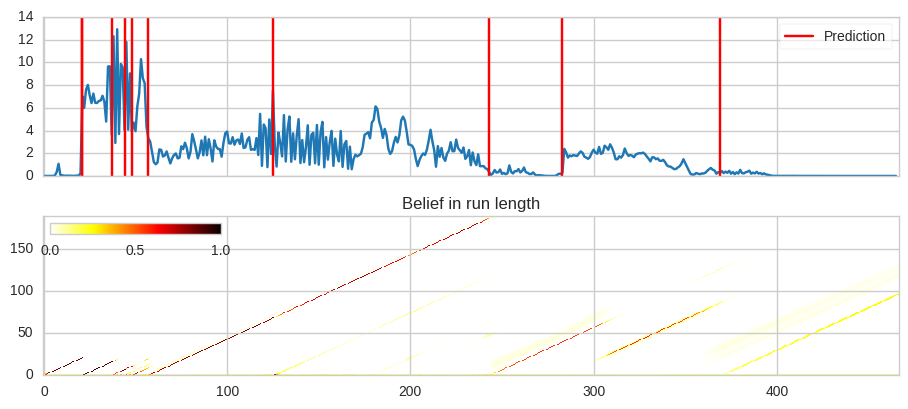

In [171]:
M = np.matrix([[0.8, 0.1, 0.1],[0.1,0.8,0.1],[0.1, 0.1, 0.8]])
f = AndreasBayesFilterSOFT(3,M, means = [13,9,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxJ:
    bcp.add_data(d)
CPDsubplotReal(maxJ-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

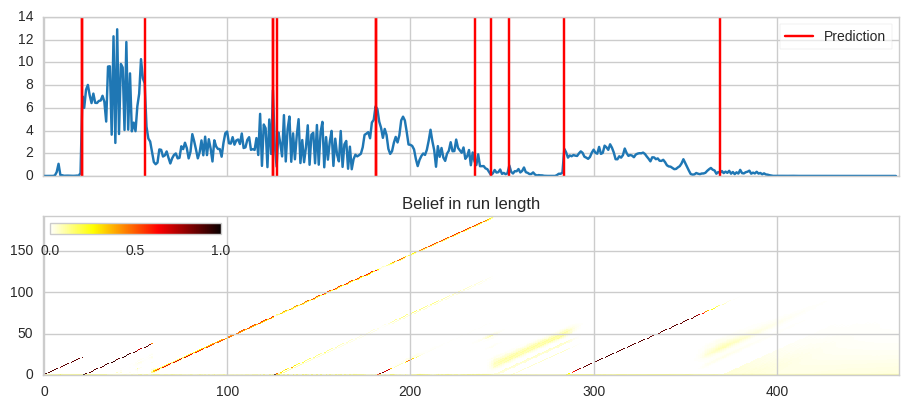

In [172]:
M = np.matrix([[0.8, 0.1, 0.1],[0.1,0.8,0.1],[0.1, 0.1, 0.8]])
f = BayesFilter(mean=[13,9,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxJ:
    bcp.add_data(d)
CPDsubplotReal(maxJ-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums, adams=False))

### Owl

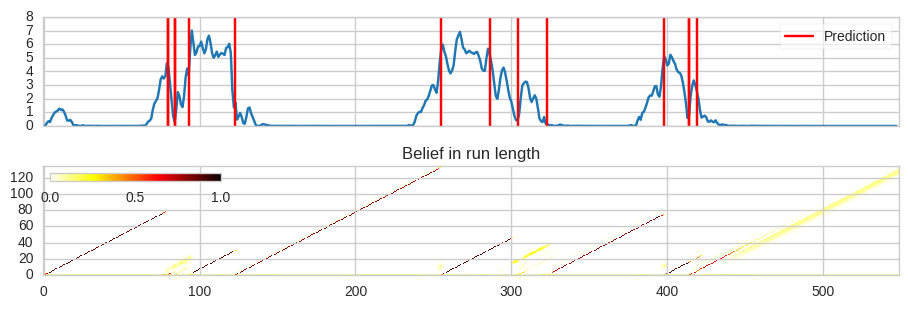

In [185]:
f = BayesFilter(mean=[10,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxOwl:
    bcp.add_data(d)
CPDsubplotReal(maxOwl-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

In [187]:
print infereCP(bcp.maximums)

[80, 84, 84, 93, 123, 255, 286, 304, 323, 398, 414, 414, 419]


/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


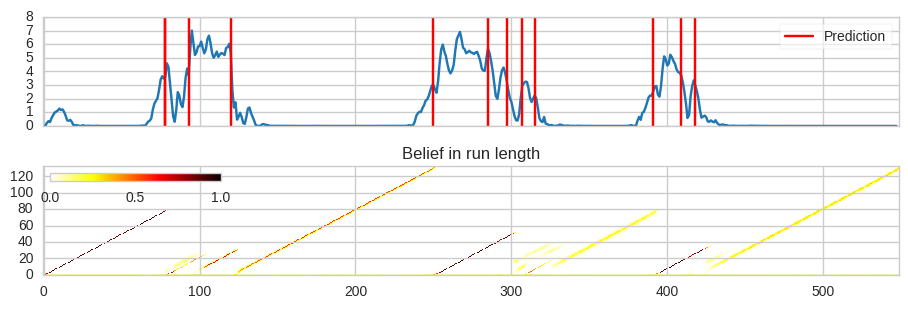

In [184]:
f = BootstrapFilterOpperMultiState(prior=[10,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxOwl:
    bcp.add_data(d)
CPDsubplotReal(maxOwl-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

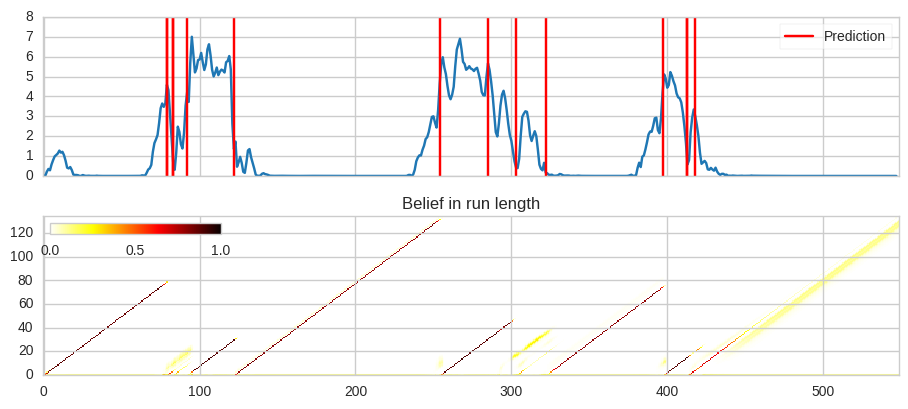

In [177]:
M = np.matrix([[0.9, 0.1],[0.1,0.9]])
f = AndreasBayesFilterSOFT(2,M, means = [10,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxOwl:
    bcp.add_data(d)
CPDsubplotReal(maxOwl-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


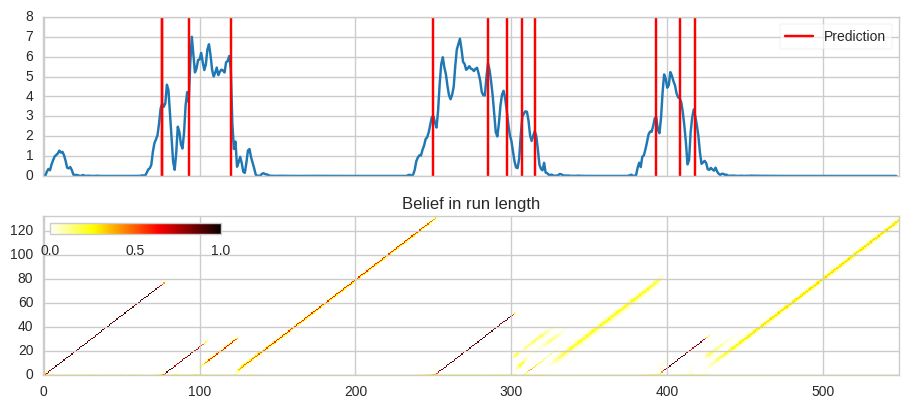

In [179]:
f = BootstrapFilterOpperMultiStateGammaPi(prior=[10,5])
bcp = BaysianChangepointDetectorGaussFilter(filter=f)
for d in maxOwl:
    bcp.add_data(d)
CPDsubplotReal(maxOwl-5, bcp.beliefs, max(bcp.maximums), infereCP(bcp.maximums))